# Описание проекта

Интернет-магазин запускает новый сервис в котором пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других.
Проект нацелен на создание инструмента, который будет искать токсичные комментарии и отправлять их на модерацию.

Обучим модель классифицировать комментарии на позитивные и негативные. Успешной моделью будет считаться та, которая достигнет метрики F1 не менее 0.75 на тестовой выборке.

---

Описание данных:
- `Unnamed: 0` — Столбец индекса, не несет полезной информации
- `text` — Текст комментария
- `toxic` — Целевая переменная, 1 — токсичный комментарий, 0 — нет.

In [166]:
# imports
import pandas as pd
import numpy as np

# Графики
import matplotlib.pyplot as plt
import seaborn as sns

# Обработка текста
import re

# Создание эмбеддингов
import torch
import transformers
from tqdm import notebook

In [167]:
# Игнорирование предупреждений:
import warnings

warnings.filterwarnings("ignore")

# Настройки воспроизводимости:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [168]:
# Настройка устройства для нейронных сетей
if torch.cuda.is_available():
    DEFAULT_DEVICE = "cuda"
elif torch.backends.mps.is_available():
    DEFAULT_DEVICE = "mps"
else:
    DEFAULT_DEVICE = "cpu"

# Проверяем устройство
DEFAULT_DEVICE

'mps'

## Загрузка данных

Загрузим данные и выведем информацию о них.

In [169]:
# Загружаем данные
df = pd.read_csv('data/toxic_comments.csv')

# Выводим датафрейм
df

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0
...,...,...,...
159287,159446,""":::::And for the second time of asking, when ...",0
159288,159447,You should be ashamed of yourself \n\nThat is ...,0
159289,159448,"Spitzer \n\nUmm, theres no actual article for ...",0
159290,159449,And it looks like it was actually you who put ...,0


In [170]:
# Выводим информацию
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


In [171]:
# Удаляем столбец
df = df.drop(columns=['Unnamed: 0'], axis=1)

# Приводим данные к нужному типу
df['text'] = df['text'].values.astype('U')  # Приводим UTF для дальнейшей обработки
df['toxic'] = df['toxic'].astype('int8')  # Приводим к типу int8 для экономии памяти

# Проверяем, корректно ли удалился столбец
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int8  
dtypes: int8(1), object(1)
memory usage: 1.4+ MB


### Вывод:

Мы загрузили данные. В датасете всего 2 столбца: `text` — текст комментария и `toxic` — целевая переменная. Удалили столбец индекса, который не несет полезной информации. Привели данные к нужному типу.

## Исследовательский анализ данных:

У нас всего 2 столбца в датасете, потому посмотрим только на распределение длинны текста и баланс классов целевой переменной

In [172]:
# Посмотрим, какой самый длинный комментарий в датасете:
df['length'] = df['text'].apply(lambda x: len(x))

# Смотрим самые большие комментарии:
df.sort_values('length', ascending=False)

,text,toxic,length
75033,IN THE NAME OF YTMND!IN THE NAME OF YTMND!IN T...,0,5000
46480,hahahahahahahahahahahahahahahahahaha vandalism...,1,5000
72066,China smells like fart. China smells like fart...,1,5000
96100,BOOTSTOOTS IS A FRIGGEN GAYFAG LOLOOOLBOOTSTOO...,1,5000
53300,BunkSteve is gay! BunkSteve is gay! BunkSteve ...,1,5000
...,...,...,...
15432,"Howdy!""",0,7
137400,"== """"""",0,6
52336,"14:53,",0,6
136820,~ J.Lo,0,6


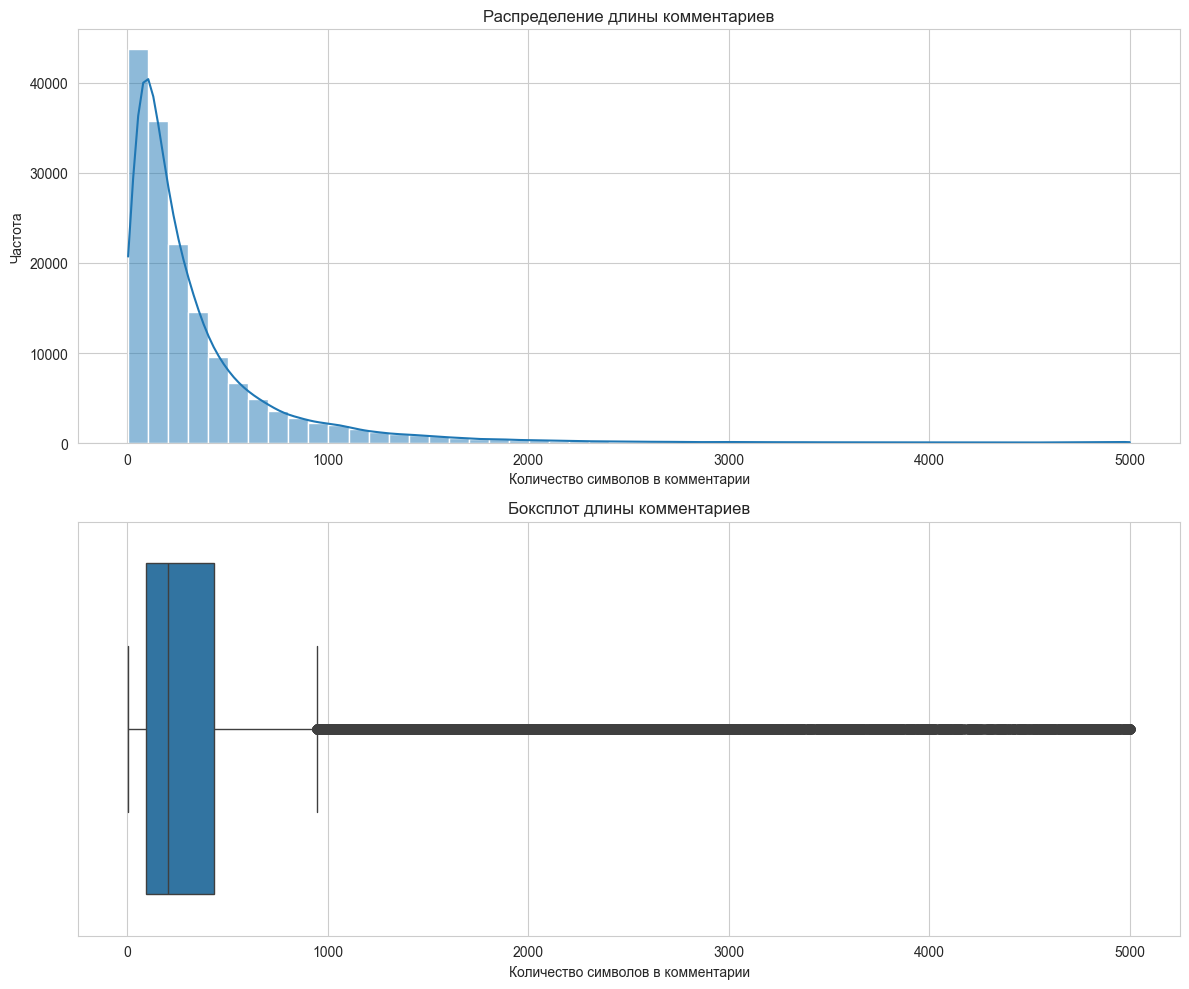

In [173]:
plt.figure(figsize=(12, 10))

# Гистограмма
plt.subplot(2, 1, 1)
sns.histplot(df['length'], bins=50, kde=True)
plt.title('Распределение длины комментариев')
plt.xlabel('Количество символов в комментарии')
plt.ylabel('Частота')

# Боксплот
plt.subplot(2, 1, 2)
sns.boxplot(x=df['length'], orient='h')
plt.title('Боксплот длины комментариев')
plt.xlabel('Количество символов в комментарии')

plt.tight_layout()
plt.show()

Мы видим, что выбросы начинаются с 1000 символов, однако распределение "выбросов" почти одинаковое. Смотря на гистограмму, мы видим, что количество комментариев с длинной более 1500 околонулевое, потому удалим их. Еще одной причиной для удаления является то, что BERT способен обрабатывать до 512 токенов, то чуть-чуть больше 1500 символов. В ином случае нам бы пришлось создавать маску размером 5000 символов, что очень сильно увеличило бы время обработки текста и обучения модели. Тем более, что большинство таких комментариев являются просто копипастом одного и того же текста, что не является полезным для обучения модели.

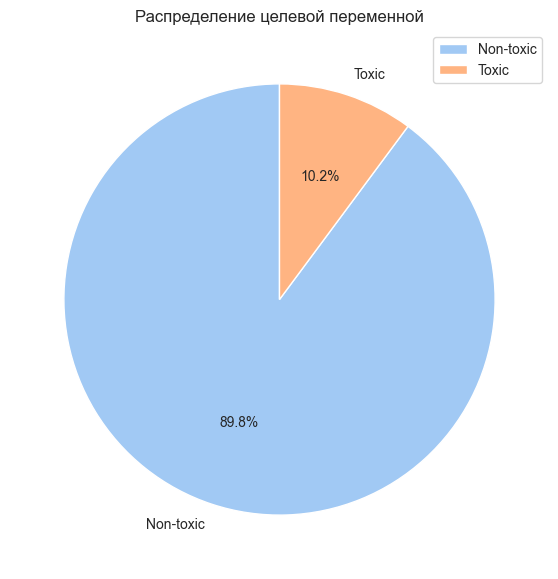

In [174]:
plt.figure(figsize=(7, 7))

# Рисуем круговую диаграмму
plt.pie(
    df['toxic'].value_counts(),
    labels=['Non-toxic', 'Toxic'],
    autopct='%1.1f%%',
    colors=sns.color_palette('pastel')[0:2],
    startangle=90,
    wedgeprops={'edgecolor': 'white'}
)
plt.title('Распределение целевой переменной')
plt.legend(labels, loc='best')

plt.show()

Мы видим, что в датасете всего 10% токсичных комментариев, потому при разбиении на обучающую и тестовую выборки стратифицируем классы

### Вывод:

Мы удалили комментарии длиной более 1200 символов, так как в ином случае нам пришлось бы создавать маску размером 5000 символов, что очень сильно увеличило бы время обработки текста и обучения модели. В датасете присутствует дисбаланс целевого признака: всего 10% токсичных комментариев, потому при разбиении на обучающую и тестовую выборки стратифицируем классы.

## Предобработка данных

Удалим комментарии длиннее 1200 символов. Так как BERT обучен на сырых данных, то излишняя предобработка может навредить. Не будем убирать пунктуацию, так как она может нести смысловую нагрузку. Также не будем приводить текст к нижнему регистру, так как BERT чувствителен к регистру, и регистр комментария может играть важную роль в тональности комментария. Удалим только вики-разметку, шаблоны и лишние переносы строк. Стоп-слова удалять не будем, потому что он может нарушить структуру предложения и снизить качество эмбеддингов.

Размер датасета после удаления выбросов: 149552


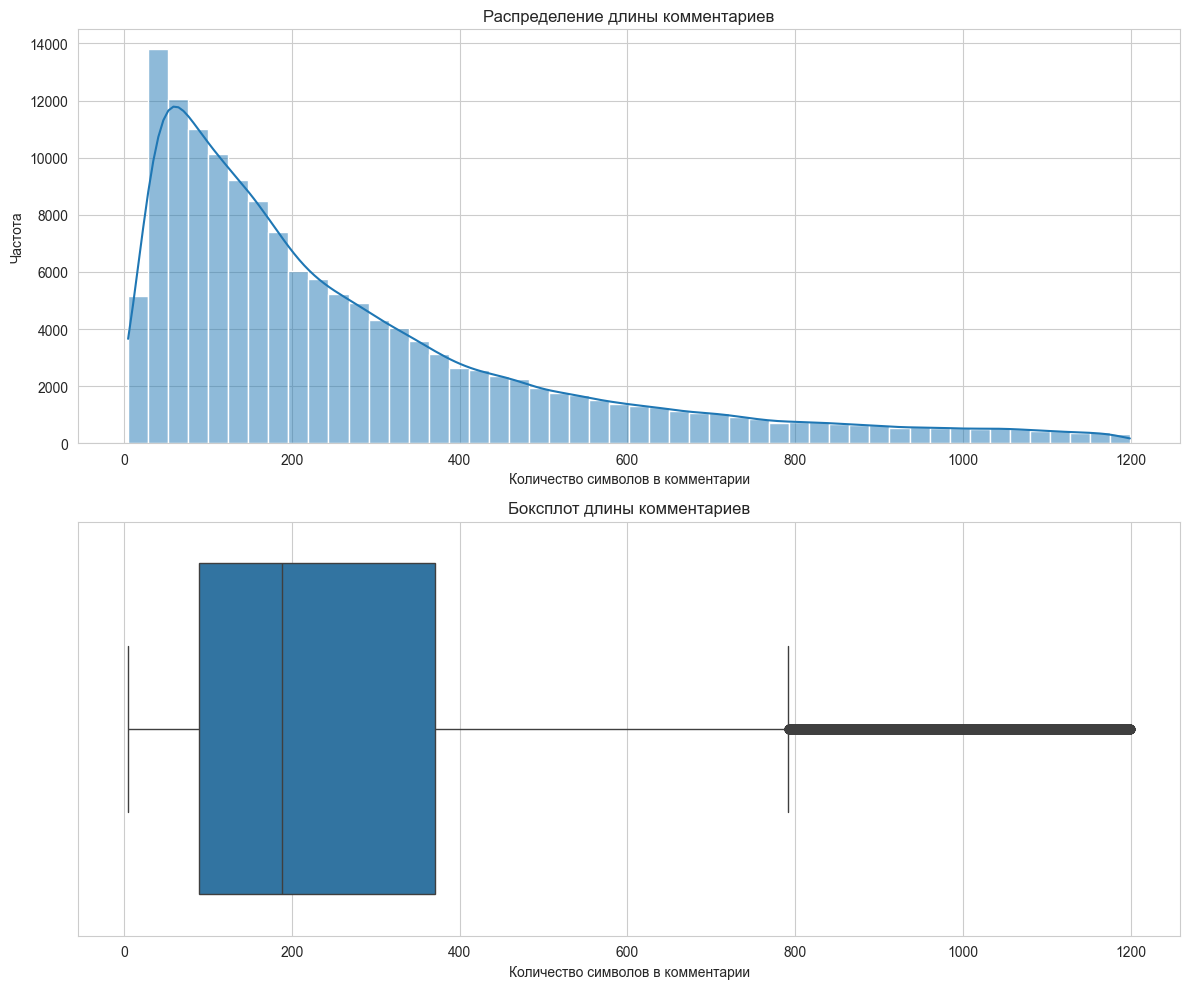

In [175]:
# Оставляем комментарии только с длиной менее 1500 символов
df = df[df['length'] < 1200].reset_index(drop=True)

# Выводим размер датасета после удаления выбросов
print(f'Размер датасета после удаления выбросов: {df.shape[0]}')

# Проверяем, что выбросы удалены
plt.figure(figsize=(12, 10))

# Гистограмма
plt.subplot(2, 1, 1)
sns.histplot(df['length'], bins=50, kde=True)
plt.title('Распределение длины комментариев')
plt.xlabel('Количество символов в комментарии')
plt.ylabel('Частота')

# Боксплот
plt.subplot(2, 1, 2)
sns.boxplot(x=df['length'], orient='h')
plt.title('Боксплот длины комментариев')
plt.xlabel('Количество символов в комментарии')

plt.tight_layout()
plt.show()

После удаления "выбросов" у нас осталось 149 000 из 159 000 комментариев. Мы удалили всего примерно 6% данных, но значительно облегчили модель

In [176]:
# Сохраняем максимальную длину комментария, чтобы создать маску
max_length = df['length'].max()

# Удаляем столбец с длиной комментария
df = df.drop(columns=['length'], axis=1)

In [177]:
def preprocess_text_for_bert(text: str) -> str:
    """
    Предобработка текста для BERT: удаление вики-разметки и лишних переносов строк.
    """
    # Удаление вики-разметки (заголовков вида == ... ==)
    text = re.sub(r'==+.*?==+', '', text)  #TODO: Удалить и проверить метрику

    # Удаление вики-шаблонов ({{...}} или незакрытых {{...)
    text = re.sub(r'\{\{[^}]*\}\}|\\{\\{.*', '', text)
    text = re.sub(r'[{|/]', ' ', text)

    # Удаление вики-ссылок вида [[...]]
    text = re.sub(r'\[\[[^\]]*]\]', '', text)

    # Удаление переносов строк
    text = re.sub(r'\n+', ' ', text)

    # Удаление лишних пробелов
    text = ' '.join(text.split())

    return text

In [178]:
# Проверяем работу функции
texts = [
    "\n\nCongratulations from me as well, use the tools well.  · talk ",
    "== A barnstar for you! ==\n\n  The Real Life Barnstar lets us be the stars\n   ",
    "{{unblock|yo",  # Незакрытый шаблон
    "{{unblock|yo}}",  # Полный шаблон
    "Text with {{template|param1|param2}} and more text",  # Шаблон внутри текста
    "Multiple {{temp1}} and {{temp2|param}} templates",  # Несколько шаблонов
    "No templates here!",  # Текст без шаблонов
]

for text in texts:
    print(preprocess_text_for_bert(text))

Congratulations from me as well, use the tools well. · talk
The Real Life Barnstar lets us be the stars
unblock yo

Text with and more text
Multiple and templates
No templates here!


In [179]:
# Очищаем текст для BERT
df['text'] = df['text'].apply(preprocess_text_for_bert)

# Выводим датасест
df

,text,toxic
0,Explanation Why the edits made under my userna...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,""" More I can't make any real suggestions on im...",0
4,"You, sir, are my hero. Any chance you remember...",0
...,...,...
149547,""":::::And for the second time of asking, when ...",0
149548,You should be ashamed of yourself That is a ho...,0
149549,"Spitzer Umm, theres no actual article for pros...",0
149550,And it looks like it was actually you who put ...,0


### Создание эмбеддингов

Для создания эмбеддингов будем использовать предобученную модель BERT на английском тексте. Она позволяет получить векторное представление текста, которое можно использовать для классификации.

In [196]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-large-cased')
model = transformers.BertModel.from_pretrained('bert-large-cased')
model.to(DEFAULT_DEVICE)  # Переносим модель на устройство

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(28996, 1024, padding_idx=0)
    (position_embeddings): Embedding(512, 1024)
    (token_type_embeddings): Embedding(2, 1024)
    (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-23): 24 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=1024, out_features=1024, bias=True)
            (key): Linear(in_features=1024, out_features=1024, bias=True)
            (value): Linear(in_features=1024, out_features=1024, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=1024, out_features=1024, bias=True)
            (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, 

In [197]:
def get_bert_embeddings(texts: list, batch_size: int = 32, device: str = DEFAULT_DEVICE):
    embeddings = []  # Список для хранения эмбеддингов
    for i in notebook.tqdm(range(0, len(texts), batch_size)):
        # Выбираем батч текстов
        batch_texts = texts[i:i + batch_size]

        # Токенизация батча
        inputs = tokenizer(batch_texts, return_tensors='pt', max_length=512, truncation=True, padding=True)

        # Переносим inputs на устройство
        inputs = {k: v.to(device) for k, v in inputs.items()}

        # Пропускаем батч через модель без градиентов (экономим память, так как не обучаем)
        with torch.no_grad():
            outputs = model(**inputs)

            # Извлекаем pooler_output и конвертируем в numpy
        batch_embeddings = outputs.pooler_output.cpu().numpy()

        # Добавляем батч эмбеддингов в общий список
        embeddings.extend(batch_embeddings)

    return embeddings

In [198]:
# # Создаем эмбеддинги
# embeddings = get_bert_embeddings(df['text'].tolist(), batch_size=128)

  0%|          | 0/1169 [00:00<?, ?it/s]

In [203]:
# # Сохраняем эмбеддинги в файл
# np.save('data/embeddings.npy', embeddings)

# Загружаем эмбеддинги из файла
embeddings = np.load('data/embeddings.npy')